In [71]:
import learn
!pip install pandas numpy matplotlib seaborn scikit-learn openpyxl


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [72]:
file_path = "Medicube.xlsx" 

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [74]:
# 实现中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [75]:
def analyze_video_data(file_path):
    """短视频数据分析主函数"""
    print(f"正在分析文件: {file_path}")
    
    # 1. 读取数据
    df = pd.read_excel(file_path)
    print(f"成功加载数据，共 {df.shape[0]} 行, {df.shape[1]} 列")
    
    # 2. 数据预处理
    # 处理数值列
    numeric_cols = ['GMV', 'Views', 'Sold Units']
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # 处理日期列
    if 'Publish Date' in df.columns:
        df['Publish Date'] = pd.to_datetime(df['Publish Date'], errors='coerce')
        df['Month'] = df['Publish Date'].dt.month
        df['Week'] = df['Publish Date'].dt.isocalendar().week
    
    # 计算派生指标
    if 'Views' in df.columns and 'Sold Units' in df.columns:
        df['Conversion Rate'] = np.where(df['Views'] > 0, (df['Sold Units'] / df['Views']) * 100, 0)
    
    if 'GMV' in df.columns and 'Views' in df.columns:
        df['ROI'] = np.where(df['Views'] > 0, df['GMV'] / df['Views'], 0)
    
    # 填充缺失值
    df = df.fillna({col: 0 for col in numeric_cols})
    
    # 3. 基础数据可视化
    create_basic_visualizations(df)
    
    # 4. 视频类型分析
    analyze_video_types(df)
    
    # 5. 账号表现分析
    analyze_accounts(df)
    
    # 6. 聚类分析
    perform_clustering(df)
    
    # 7. 特征重要性分析
    analyze_feature_importance(df)
    
    return df

In [76]:
def create_basic_visualizations(df):
    """创建基础数据可视化"""
    print("\n创建基础数据可视化...")
    
    # GMV分布
    if 'GMV' in df.columns:
        plt.figure(figsize=(10, 6))
        sns.histplot(df['GMV'].dropna(), kde=True, bins=30)
        plt.title('GMV分布')
        plt.xlabel('GMV')
        plt.ylabel('频次')
        plt.savefig('GMV分布.png')
    
    # 转化率与ROI散点图
    if all(col in df.columns for col in ['Conversion Rate', 'ROI', 'GMV']):
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(
            df['Conversion Rate'], 
            df['ROI'], 
            s=df['GMV']/df['GMV'].max()*300, # 点大小按GMV缩放
            alpha=0.6
        )
        plt.title('转化率 vs ROI (点大小表示GMV)')
        plt.xlabel('转化率 (%)')
        plt.ylabel('ROI')
        plt.grid(True)
        plt.savefig('转化率vs ROI.png')
    
    # GMV和观看量的相关性
    if all(col in df.columns for col in ['GMV', 'Views']):
        plt.figure(figsize=(10, 8))
        plt.scatter(df['Views'], df['GMV'], alpha=0.6)
        plt.title('GMV vs 观看量')
        plt.xlabel('观看量')
        plt.ylabel('GMV')
        plt.grid(True)
        
        # 添加趋势线
        z = np.polyfit(df['Views'].dropna(), df['GMV'].dropna(), 1)
        p = np.poly1d(z)
        plt.plot(df['Views'], p(df['Views']), "r--", alpha=0.8)
        plt.savefig('GMV vs 观看量.png')
    
    print("基础可视化已保存")

In [77]:
def analyze_video_types(df):
    """分析视频类型表现"""
    if '视频类型' not in df.columns:
        return
    
    print("\n分析视频类型表现...")
    
    # 按视频类型统计绩效
    type_perf = df.groupby('视频类型').agg({
        'GMV': ['count', 'sum', 'mean'],
        'Views': ['sum', 'mean'],
        'Sold Units': ['sum', 'mean'],
        'Conversion Rate': 'mean' if 'Conversion Rate' in df.columns else 'count',
        'ROI': 'mean' if 'ROI' in df.columns else 'count'
    })
    
    # 扁平化多层次索引
    type_perf.columns = ['_'.join(col).strip() for col in type_perf.columns.values]
    type_perf = type_perf.rename(columns={
        'GMV_count': '视频数量',
        'GMV_sum': '总GMV',
        'GMV_mean': '平均GMV',
        'Views_sum': '总观看量',
        'Views_mean': '平均观看量',
        'Sold Units_sum': '总销售量',
        'Sold Units_mean': '平均销售量',
        'Conversion Rate_mean': '平均转化率',
        'ROI_mean': '平均ROI'
    })
    
    # 只考虑有至少3个视频的类型
    type_perf_filtered = type_perf[type_perf['视频数量'] >= 3]
    if type_perf_filtered.empty:
        return
    
    # 按平均GMV排序
    type_perf_sorted = type_perf_filtered.sort_values('平均GMV', ascending=False)
    
    # 绘制视频类型表现对比图
    plt.figure(figsize=(12, 10))
    
    # 平均GMV对比
    plt.subplot(2, 2, 1)
    bars = plt.bar(type_perf_sorted.index, type_perf_sorted['平均GMV'])
    plt.title('各视频类型平均GMV')
    plt.xticks(rotation=45, ha='right')
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
                f'{bar.get_height():.0f}', ha='center', va='bottom')
    
    # 平均观看量对比
    plt.subplot(2, 2, 2)
    bars = plt.bar(type_perf_sorted.index, type_perf_sorted['平均观看量'])
    plt.title('各视频类型平均观看量')
    plt.xticks(rotation=45, ha='right')
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
                f'{bar.get_height():.0f}', ha='center', va='bottom')
    
    # 平均转化率对比
    if '平均转化率' in type_perf_sorted.columns:
        plt.subplot(2, 2, 3)
        bars = plt.bar(type_perf_sorted.index, type_perf_sorted['平均转化率'])
        plt.title('各视频类型平均转化率(%)')
        plt.xticks(rotation=45, ha='right')
        for bar in bars:
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2, 
                    f'{bar.get_height():.2f}%', ha='center', va='bottom')
    
    # 平均ROI对比
    if '平均ROI' in type_perf_sorted.columns:
        plt.subplot(2, 2, 4)
        bars = plt.bar(type_perf_sorted.index, type_perf_sorted['平均ROI'])
        plt.title('各视频类型平均ROI')
        plt.xticks(rotation=45, ha='right')
        for bar in bars:
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
                    f'{bar.get_height():.4f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig('视频类型表现对比.png')
    print("视频类型分析图表已保存")


正在分析文件: Medicube.xlsx


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

成功加载数据，共 270 行, 25 列

创建基础数据可视化...


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

基础可视化已保存

分析视频类型表现...

分析账号表现...


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

账号表现分析图表已保存

执行视频聚类分析...


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

聚类分析图表已保存

分析特征重要性...


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

特征重要性分析图表已保存

分析完成！所有图表已保存。


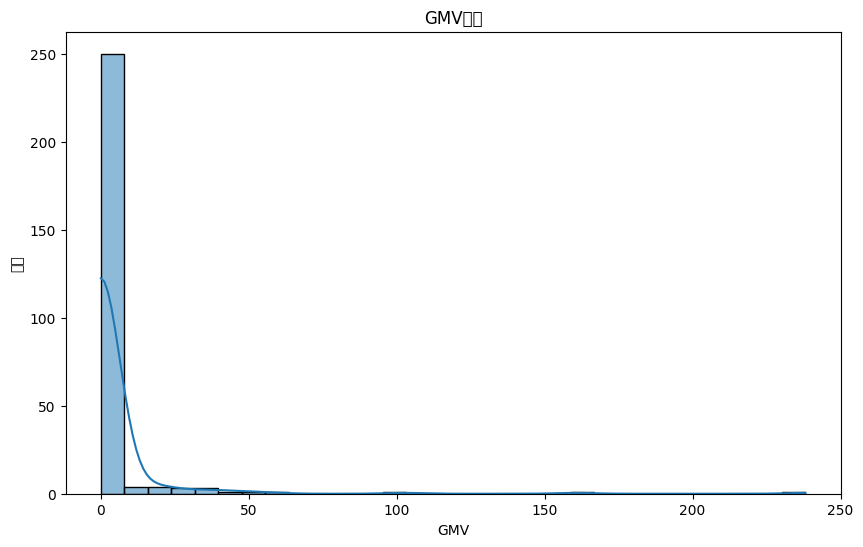

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

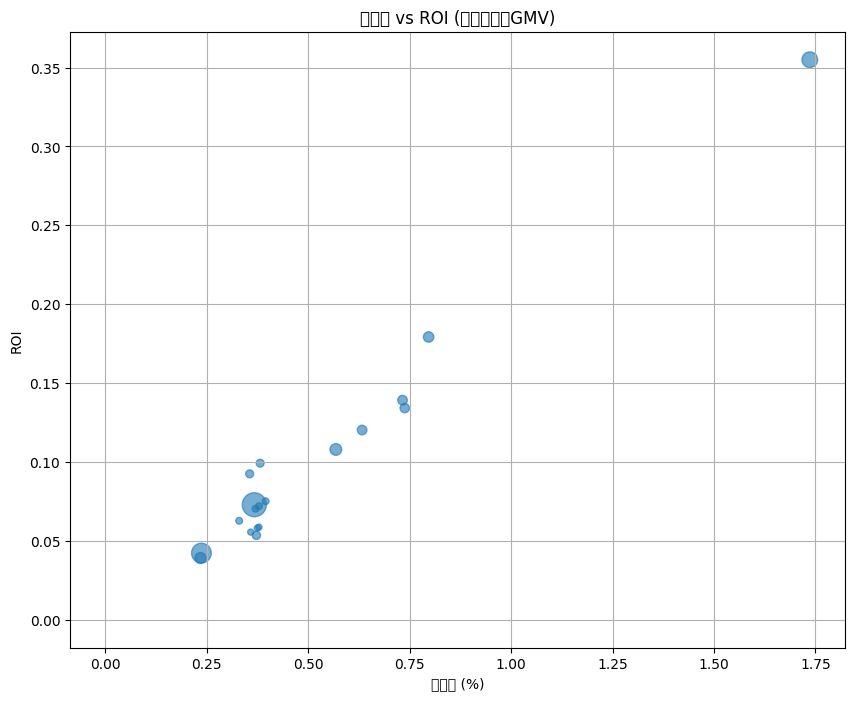

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

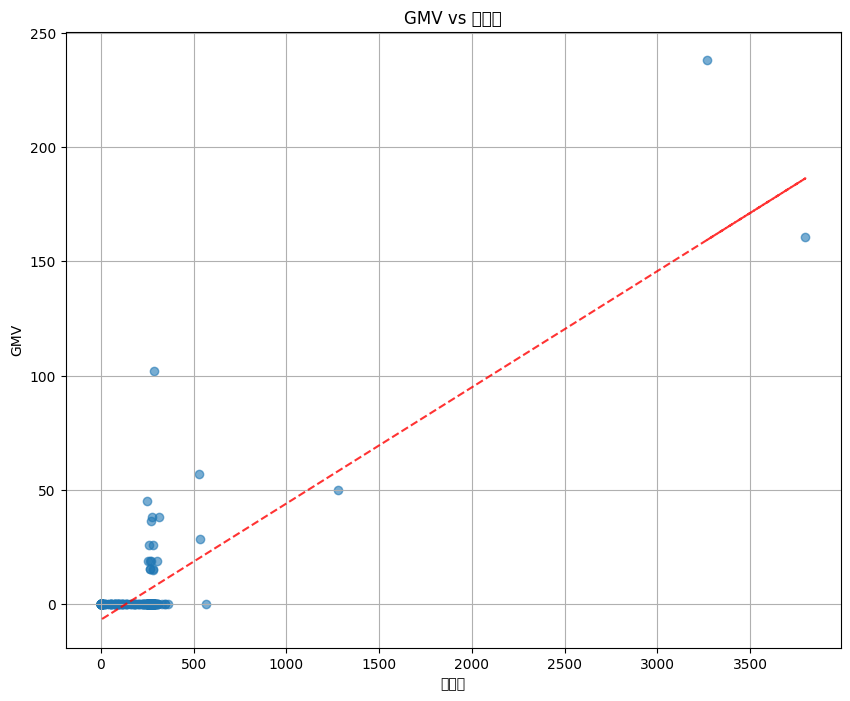

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

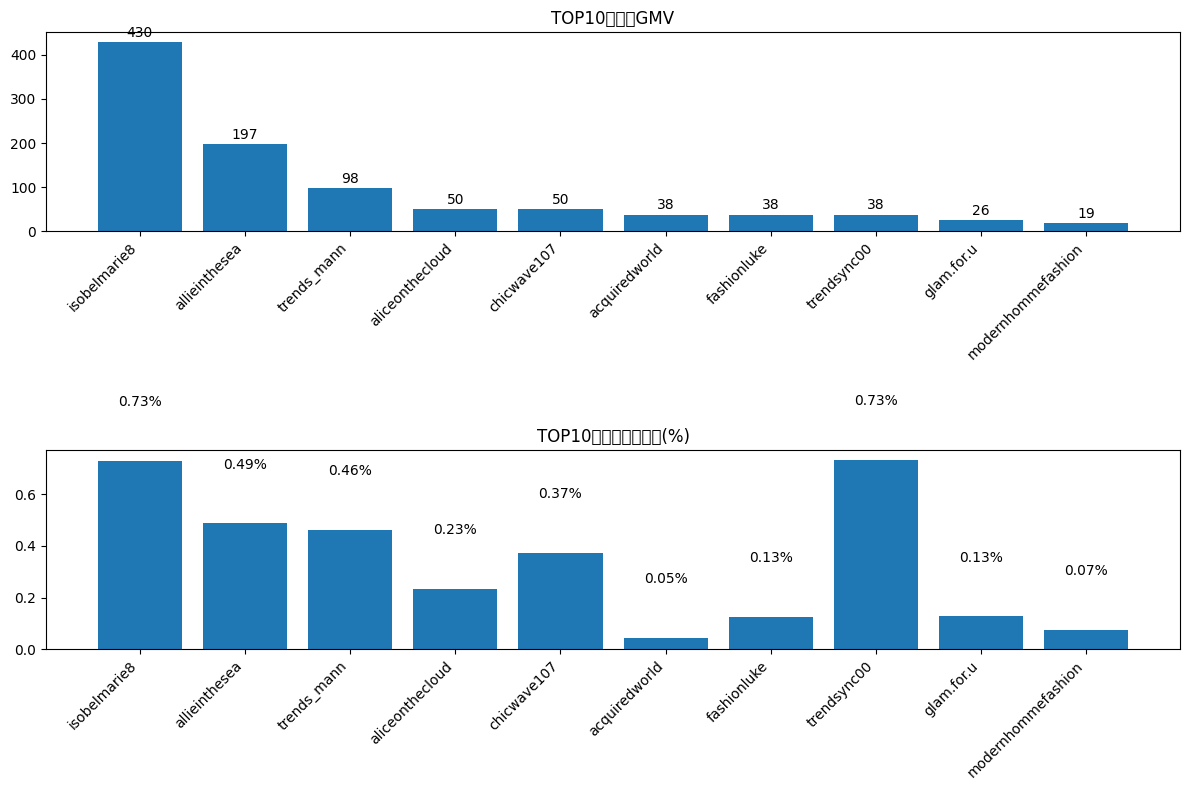

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

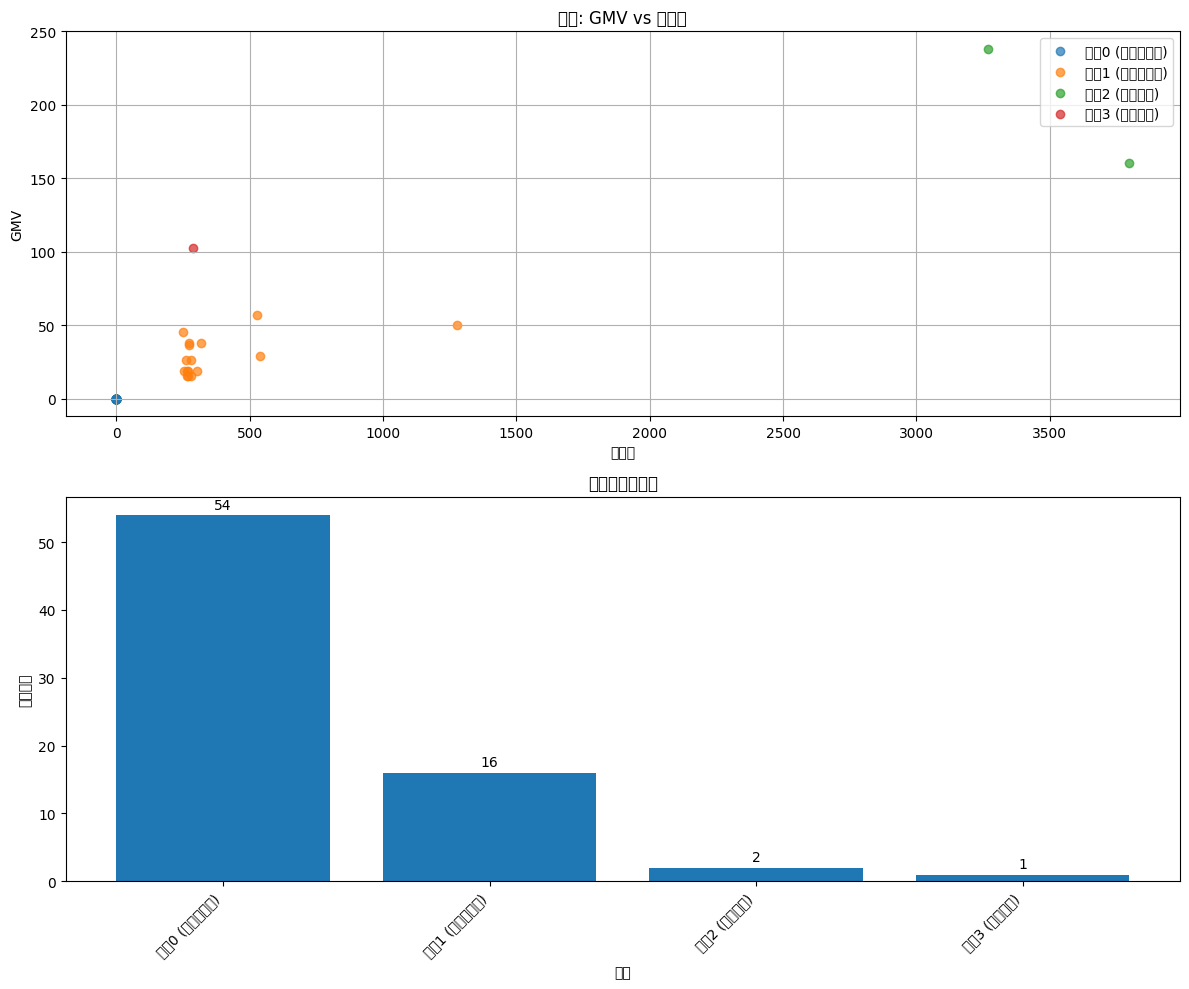

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

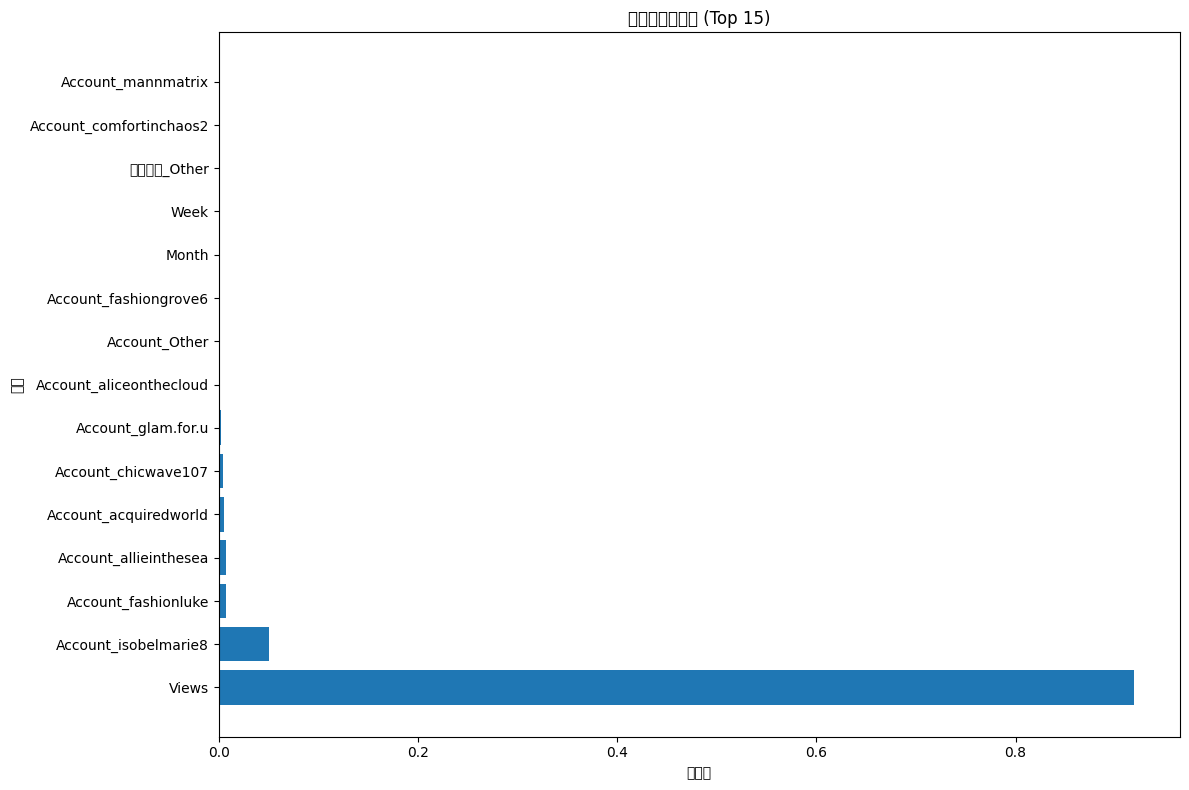

In [78]:
def analyze_accounts(df):
    """分析账号表现"""
    if 'Account' not in df.columns:
        return
    
    print("\n分析账号表现...")
    
    # 按账号统计绩效
    account_perf = df.groupby('Account').agg({
        'GMV': ['count', 'sum', 'mean'],
        'Views': ['sum', 'mean'],
        'Sold Units': ['sum', 'mean'],
        'Conversion Rate': 'mean' if 'Conversion Rate' in df.columns else 'count',
        'ROI': 'mean' if 'ROI' in df.columns else 'count'
    })
    
    # 扁平化多层次索引
    account_perf.columns = ['_'.join(col).strip() for col in account_perf.columns.values]
    account_perf = account_perf.rename(columns={
        'GMV_count': '视频数量',
        'GMV_sum': '总GMV',
        'GMV_mean': '平均GMV',
        'Views_sum': '总观看量',
        'Views_mean': '平均观看量',
        'Sold Units_sum': '总销售量',
        'Sold Units_mean': '平均销售量',
        'Conversion Rate_mean': '平均转化率',
        'ROI_mean': '平均ROI'
    })
    
    # 只显示至少发布3个视频的账号
    account_perf_filtered = account_perf[account_perf['视频数量'] >= 3]
    if account_perf_filtered.empty:
        return
    
    # 按总GMV排序
    top_accounts = account_perf_filtered.sort_values('总GMV', ascending=False).head(10)
    
    # 绘制账号表现图
    plt.figure(figsize=(12, 8))
    
    # 总GMV对比
    plt.subplot(2, 1, 1)
    bars = plt.bar(top_accounts.index, top_accounts['总GMV'])
    plt.title('TOP10账号总GMV')
    plt.xticks(rotation=45, ha='right')
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
                f'{bar.get_height():.0f}', ha='center', va='bottom')
    
    # 平均转化率对比
    if '平均转化率' in top_accounts.columns:
        plt.subplot(2, 1, 2)
        bars = plt.bar(top_accounts.index, top_accounts['平均转化率'])
        plt.title('TOP10账号平均转化率(%)')
        plt.xticks(rotation=45, ha='right')
        for bar in bars:
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2, 
                    f'{bar.get_height():.2f}%', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig('账号表现TOP10.png')
    print("账号表现分析图表已保存")

def perform_clustering(df):
    """聚类分析"""
    print("\n执行视频聚类分析...")
    
    # 检查必要的列
    required_cols = ['GMV', 'Views']
    if not all(col in df.columns for col in required_cols):
        return
    
    # 准备聚类数据
    cluster_features = ['GMV', 'Views']
    if 'Conversion Rate' in df.columns:
        cluster_features.append('Conversion Rate')
    if 'ROI' in df.columns:
        cluster_features.append('ROI')
    
    # 过滤有效数据行
    cluster_data = df[cluster_features].dropna()
    if len(cluster_data) < 10:
        return
    
    # 标准化数据
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(cluster_data)
    
    # 应用K-means聚类 (固定使用4个聚类)
    n_clusters = 4
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    
    # 创建带有聚类标签的DataFrame
    df_with_clusters = df.copy()
    df_with_clusters = df_with_clusters.dropna(subset=cluster_features)
    df_with_clusters['Cluster'] = kmeans.fit_predict(scaled_data)
    
    # 分析每个聚类的特征
    cluster_profiles = df_with_clusters.groupby('Cluster').agg({
        'GMV': ['count', 'mean'],
        'Views': 'mean',
        'Conversion Rate': 'mean' if 'Conversion Rate' in df.columns else 'count'
    })
    
    # 扁平化多层次索引
    cluster_profiles.columns = ['_'.join(col).strip() for col in cluster_profiles.columns.values]
    
    # 对聚类进行命名
    cluster_names = []
    for i in range(n_clusters):
        profile = cluster_profiles.iloc[i]
        
        # 基于GMV和观看量的组合来命名
        if profile['GMV_mean'] > cluster_profiles['GMV_mean'].median():
            if profile['Views_mean'] > cluster_profiles['Views_mean'].median():
                name = "明星视频" # 高GMV高观看量
            else:
                name = "小众精品" # 高GMV低观看量
        else:
            if profile['Views_mean'] > cluster_profiles['Views_mean'].median():
                name = "流量无转化" # 低GMV高观看量
            else:
                name = "待优化视频" # 低GMV低观看量
        
        cluster_names.append(f"聚类{i} ({name})")
    
    # 绘制聚类散点图
    plt.figure(figsize=(12, 10))
    
    # GMV vs Views
    plt.subplot(2, 1, 1)
    for cluster in range(n_clusters):
        cluster_data = df_with_clusters[df_with_clusters['Cluster'] == cluster]
        plt.scatter(
            cluster_data['Views'], 
            cluster_data['GMV'],
            label=cluster_names[cluster],
            alpha=0.7
        )
    plt.xlabel('观看量')
    plt.ylabel('GMV')
    plt.title('聚类: GMV vs 观看量')
    plt.legend()
    plt.grid(True)
    
    # 显示每个聚类的视频数量
    plt.subplot(2, 1, 2)
    bars = plt.bar(cluster_names, cluster_profiles['GMV_count'])
    plt.xlabel('聚类')
    plt.ylabel('视频数量')
    plt.title('各聚类视频数量')
    plt.xticks(rotation=45, ha='right')
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                f'{bar.get_height():.0f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig('聚类分析结果.png')
    print("聚类分析图表已保存")

def analyze_feature_importance(df):
    """特征重要性分析"""
    print("\n分析特征重要性...")
    
    # 检查必要的列
    target_col = 'GMV'
    if target_col not in df.columns:
        return
    
    # 准备特征列
    features = []
    
    # 数值特征
    numeric_features = ['Views']
    for col in numeric_features:
        if col in df.columns:
            features.append(col)
    
    # 时间特征
    time_features = ['Month', 'Week']
    for col in time_features:
        if col in df.columns:
            features.append(col)
    
    # 分类特征(转为哑变量)
    categorical_features = ['视频类型', 'Account', 'Product']
    cat_dummies = []
    
    for col in categorical_features:
        if col in df.columns:
            # 只选择出现频率前10的类别，避免特征过多
            top_categories = df[col].value_counts().nlargest(10).index
            df[f'{col}_filtered'] = df[col].apply(lambda x: x if x in top_categories else 'Other')
            # 创建哑变量
            dummies = pd.get_dummies(df[f'{col}_filtered'], prefix=col)
            cat_dummies.append(dummies)
    
    # 准备数据
    X = df[features].copy() if features else pd.DataFrame(index=df.index)
    
    # 合并哑变量
    for dummies in cat_dummies:
        X = pd.concat([X, dummies], axis=1)
    
    # 如果没有足够的特征，返回
    if X.shape[1] < 2:
        return
    
    # 目标变量
    y = df[target_col]
    
    # 过滤掉缺失值
    valid_idx = ~X.isna().any(axis=1) & ~y.isna()
    X = X[valid_idx]
    y = y[valid_idx]
    
    if len(X) < 10:
        return
    
    # 分割训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # 训练随机森林回归模型
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    
    # 提取特征重要性
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': rf_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    # 绘制特征重要性图
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(15)
    plt.barh(top_features['Feature'], top_features['Importance'])
    plt.xlabel('重要性')
    plt.ylabel('特征')
    plt.title('特征重要性排名 (Top 15)')
    plt.tight_layout()
    plt.savefig('特征重要性.png')
    print("特征重要性分析图表已保存")

# 主函数
if __name__ == "__main__":
    file_path = "Medicube.xlsx"  # 可以修改为实际文件路径
    df = analyze_video_data(file_path)
    print("\n分析完成！所有图表已保存。")